# 1. Sơ đồ ERD & Data Quality

**Sơ đồ ERD**
![ERD.PNG] (images/ERD.PNG)
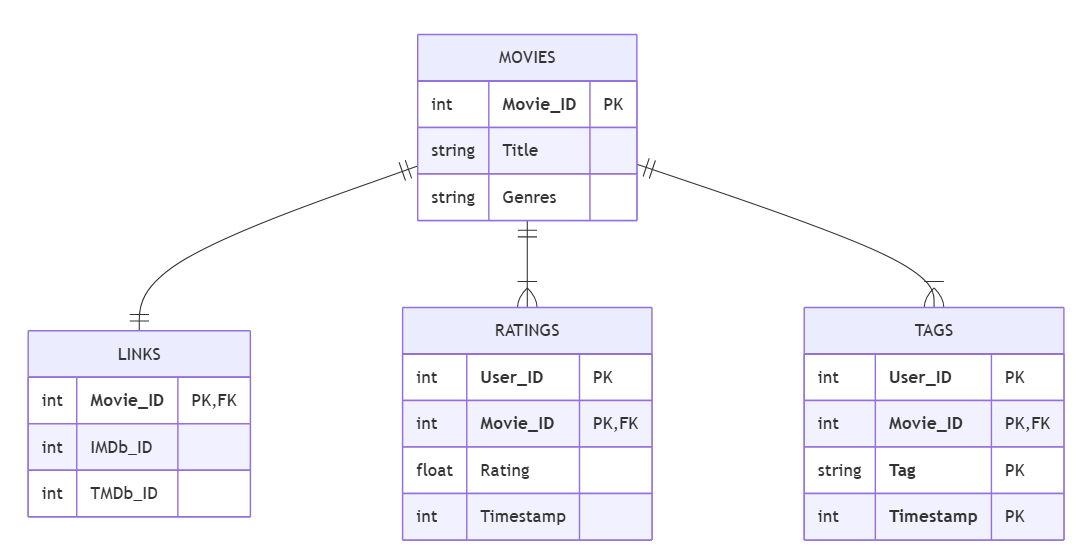

**Phân tích định lượng tập dữ liệu**

**Quy mô dữ liệu**:

*   Ratings: 100,836 bản ghi (tương tác điểm số)
*   Movies: 9,742 bộ phim, vs nhiều thể loại
*   Tags: 3,683 từ khóa phân loại định tính từ người dùng
*   Links: 9,742 iên kết định danh sang IMDb và TMDB

**Ngưỡng tương tác**: 610 users đã thực hiện đánh giá ít nhất 20 bộ phim

**Thống kê thực thể & Độ loãng ma trận:**

*   User (U): 610
*   Movies (M): 9,742
*   Tổng số ô trong ma trận (U x M): 5,942,620 vị trí có thể có điểm
*   Ratings (R): 100,836
*   Tỷ lệ lấp đầy: 100.836/5.942.620 = 1.7%
*   Độ loãng: 98.3%

=> Với độ loãng 98.3%, dữ liệu cực kỳ thưa thớt, trung bình một người dùng chỉ mới xem và đánh giá chưa tới 2% tổng kho phim.






**Data health check**

*  Dữ liệu trống: 0 ( 13 phim lỗi định dạng <=> 0.13% phim không trích xuất được năm phát hành => không ảnh hưởng tới kết quả, có thể bỏ or không)
*  Tính toàn vẹn: 100% movies_id đồng bộ giữa các bảng
*   Ngưỡng đánh giá: Đạt tiêu chuẩn mỗi user >= 20 ratings
*   Độ loãng ma trận: ~ 98.3%

Công thức:
$$Sparsity (\%) = \left( 1 - \frac{\text{Số lượng đánh giá thực tế}}{\text{Người dùng} \times \text{Phim}} \right) \times 100$$







In [ ]:
import pandas as pd

# Cấu hình hệ thống
FILES = {'Ratings': 'ratings.csv', 'Movies': 'movies.csv', 'Tags': 'tags.csv', 'Links': 'links.csv'}

def run_deep_audit():
    dfs = {name: pd.read_csv(path) for name, path in FILES.items()}

    # 1.Ktra tong quan
    print("      == Data Overview Report ==")
    print(f"{'Table':<10} | {'Row':<10} | {'Null':<5} | {'Duplicate':<10}")
    print("-" * 45)
    for name, df in dfs.items():
        nulls = df.isnull().sum().sum()
        dups = df.duplicated().sum()
        status = "" + str(nulls) if nulls > 0 else "0"
        print(f"{name:<10} | {len(df):<10,} | {status:<5} | {dups:<10}")

    # 2. Ktra tinh nhat quan
    print("\n      == Integrity Check (Foreign keys) ==")
    master_ids = set(dfs['Movies']['movieId'])
    for name in ['Ratings', 'Tags', 'Links']:
        missing = len(set(dfs[name]['movieId']) - master_ids)
        status = "100% match" if missing == 0 else f" Missing {missing} Movies ID"
        print(f"Movies ↔ {name:<8}: {status}")

    # 3. Ktra quy tac nghiep vụ
    print("\n      == Rule check ==")

    # Check 1: Thang điểm (Expected 0.5 - 5.0)
    r_min, r_max = dfs['Ratings']['rating'].min(), dfs['Ratings']['rating'].max()
    print(f"1. Actual rating scale  : {r_min} - {r_max} {'(Valid)' if r_min >= 0.5 and r_max <= 5 else 'Out of range'}")

    # Check 2: Quy tắc 20 ratings/user
    min_user_ratings = dfs['Ratings'].groupby('userId').size().min()
    print(f"2. Min rating/user: {min_user_ratings} {'(Met 20+ standard)' if min_user_ratings >= 20 else '❌'}")

    # Check 3: Trích xuất năm
    years = dfs['Movies']['title'].str.extract(r'\((\d{4})\)')[0]
    print(f"3. Year format errors   : {years.isna().sum()} movies {'(Action required)' if years.isna().sum() > 0 else ''}")

    # 4. Sparsity
    n_users = dfs['Ratings']['userId'].nunique()
    n_movies = dfs['Movies']['movieId'].nunique()
    sparsity = (1 - (len(dfs['Ratings']) / (n_users * n_movies))) * 100
    print(f"\n   => Data sparsity metric: {sparsity:.2f}%")

# Thực thi audit
run_deep_audit()

      == Data Overview Report ==
Table      | Row        | Null  | Duplicate 
---------------------------------------------
Ratings    | 100,836    | 0     | 0         
Movies     | 9,742      | 0     | 0         
Tags       | 3,683      | 0     | 0         
Links      | 9,742      | 8     | 0         

      == Integrity Check (Foreign keys) ==
Movies ↔ Ratings : 100% match
Movies ↔ Tags    : 100% match
Movies ↔ Links   : 100% match

      == Rule check ==
1. Actual rating scale  : 0.5 - 5.0 (Valid)
2. Min rating/user: 20 (Met 20+ standard)
3. Year format errors   : 13 movies (Action required)

   => Data sparsity metric: 98.30%


# 2. Chart (EDA)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Nạp dữ liệu một lần duy nhất tại đây
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

**Chart 1: Ratings per Use** - Phân phối số lượng đánh giá trên mỗi người dùng => Xác nhận độ tích cực của 610 users (min 20 ratings/user)

Tác động mô hình ALS:

*   Giải quyết bài toán Cold Start: Mỗi người dùng có ít nhất 20 ratings, thuật toán ALS có đủ mẫu sở thích để xây dựng các Vector đặc tính ẩn (Latent Factors) chính xác ngay từ đầu
* Độ loãng của ma trận (Sparsity): Mỗi người đánh giá tối thiểu 20 phim, nhưng so với tổng số 9,742 phim trong hệ thống, ma trận dữ liệu vẫn thưa thớt => sử dụng Spark ALS để tính toán hiệu quả




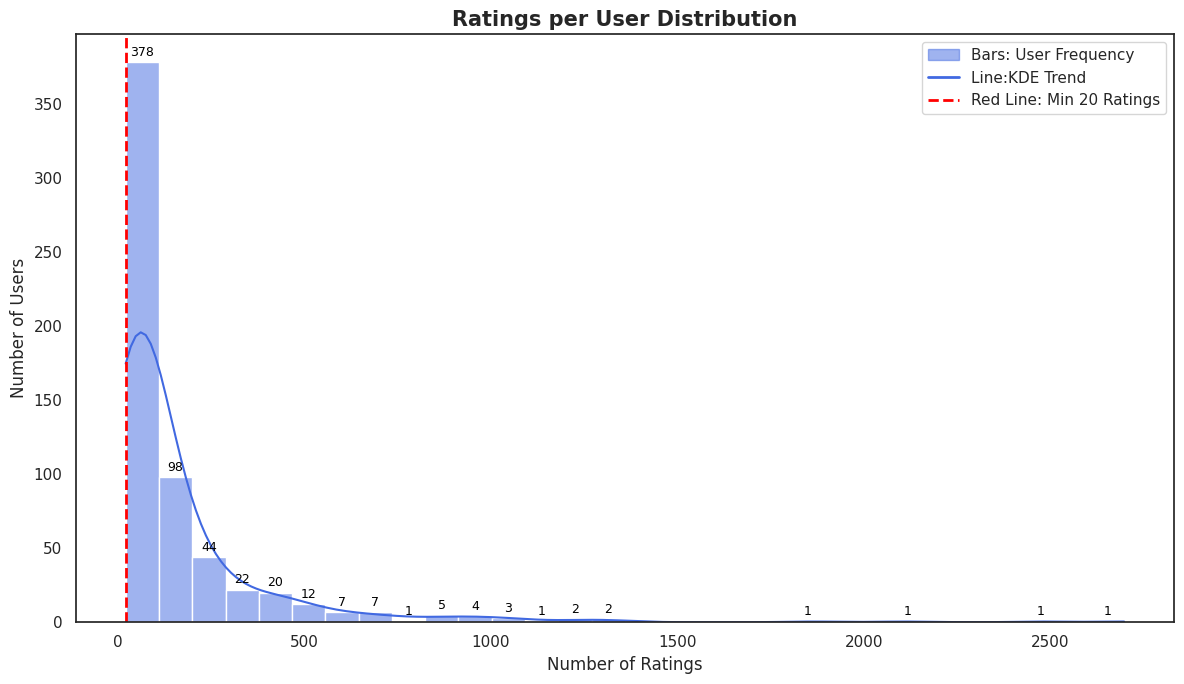

Minimum ratings by a single user: 20
Total unique users: 610


In [9]:
# Tính số lượng đánh giá cho user
user_counts = ratings.groupby('userId').size().reset_index(name='rating_count')

plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

# Chart
ax = sns.histplot(data=user_counts, x='rating_count', bins=30, color='royalblue', kde=True)

# Redline đánh dấu mốc 20 ratings (Quy định của GroupLens)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2)

# Notes
custom_legend_elements = [
    plt.Rectangle((0,0), 1, 1, color='royalblue', alpha=0.5, label='Bars: User Frequency'),
    Line2D([0], [0], color='royalblue', lw=2, label='Line:KDE Trend'),
    Line2D([0], [0], color='red', linestyle='--', lw=2, label='Red Line: Min 20 Ratings')
]
plt.legend(handles=custom_legend_elements, loc='upper right', fontsize=11)

# 6. Title
plt.title('Ratings per User Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

# 7. Number on column
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    fontsize=9, color='black',
                    xytext=(0, 7),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

# Kiểm chứng thông số
print(f"Minimum ratings by a single user: {user_counts['rating_count'].min()}")
print(f"Total unique users: {user_counts['userId'].nunique()}")

**Chart 2: Ratings Distribution** (Phân phối điểm số => xem xu hướng chấm điểm)

**Quy mô dữ liệu**: Biểu đồ thể hiện tổng cộng 100.836 lượt đánh giá cho 9.742 bộ phim

**Thang điểm**: Đánh giá trên thang điểm từ 0.5 - 5 sao với bước nhảy 0.5

**Cmt:**
* Mức điểm 4 và 3 chiếm tỷ lệ cao, người dùng có xu hướng đánh giá tích cực hoặc thường dành thời gian xem và đánh giá những bộ phim họ quan tâm.

* Các mức điểm nửa sao (như 0.5, 1.5, 2.5) có tỷ lệ thấp hơn các mức điểm đánh giá nguyên sao cho thấy thói quen chấm điểm nhanh của người dùng
* **Tác động đến ALS**: Dữ liệu tập trung nhiều ở mức 3.0 - 5.0 giúp mô hình học được các đặc tính ẩn của những bộ phim được yêu thích tốt hơn








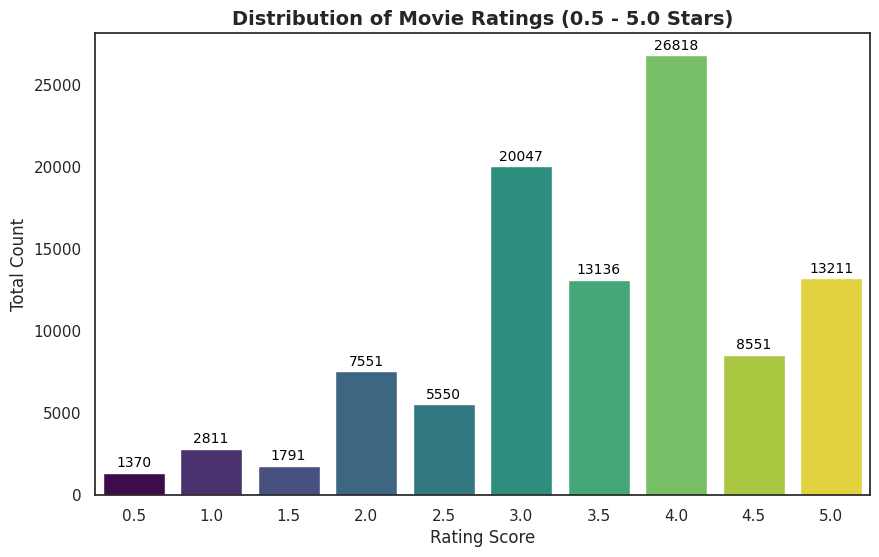

In [12]:
sns.set_theme(style="white")

# Distribution of Ratings
plt.figure(figsize=(10, 6))
ax1 = sns.countplot(data=ratings, x='rating', hue='rating', palette='viridis', legend=False)

plt.title('Distribution of Movie Ratings (0.5 - 5.0 Stars)', fontsize=14, fontweight='bold')
plt.xlabel('Rating Score')
plt.ylabel('Total Count')

# Number on column
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 7),
                textcoords='offset points')
plt.show()

**Chart 3: Top 10 Most Rated Movies**

Tính nhất quán: Biểu đồ được trích xuất dựa trên mã movieId đồng bộ giữa các tệp ratings.csv và movies.csv

Cmt:
* Danh sách dẫn đầu bởi các phim kinh điển (như Forrest Gump, Pulp Fiction, The Shawshank Redemption)

* Những bộ phim có tương tác cao nhất, đóng vai trò là anchors quan trọng trong **thuật toán Collaborative Filtering** để tìm kiếm sự tương đồng giữa các người dùng.
* Một bộ phim trong top có thể có hàng trăm lượt đánh giá, trong khi trung bình mỗi người dùng trong tập dữ liệu này chỉ đánh giá ít nhất 20 phim





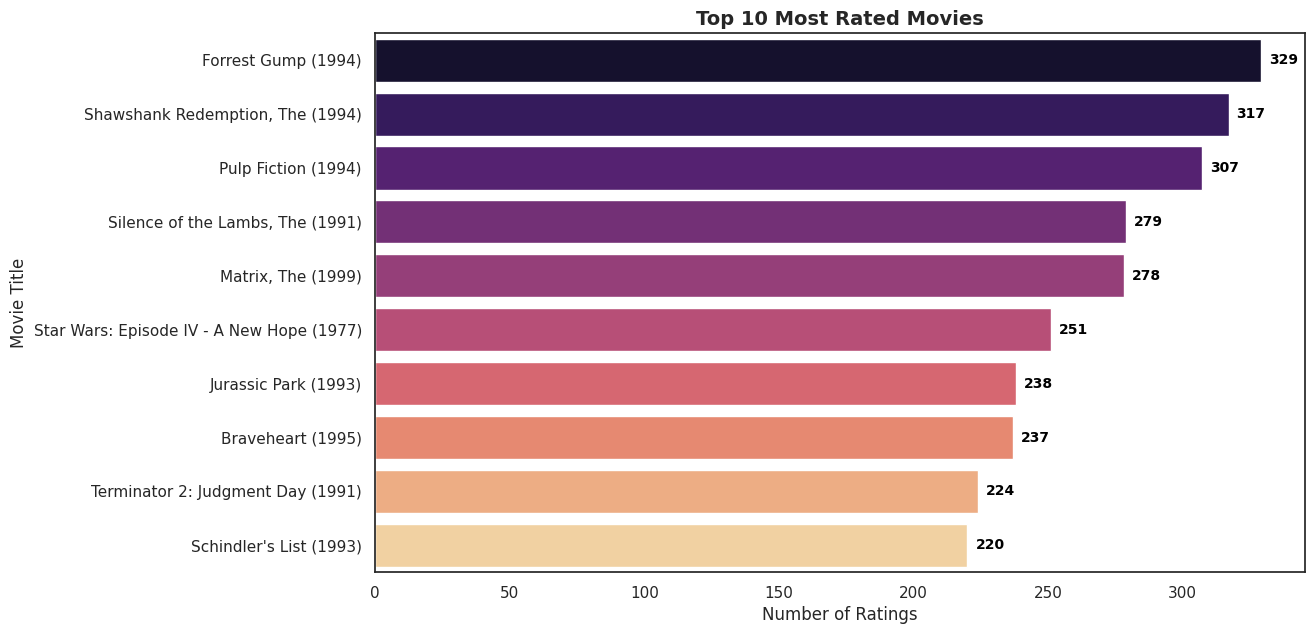

In [ ]:
# Top 10 Most Rated Movies
movie_counts = ratings.groupby('movieId').size().reset_index(name='count')
top_10 = pd.merge(movie_counts, movies, on='movieId').sort_values('count', ascending=False).head(10)

plt.figure(figsize=(12, 7))
ax2 = sns.barplot(data=top_10, x='count', y='title', hue='title', palette='magma', legend=False)

plt.title('Top 10 Most Rated Movies', fontsize=14, fontweight='bold')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')

# Number on column
for i, v in enumerate(top_10['count']):
    ax2.text(v + 3, i, str(v), color='black', va='center', fontweight='bold', fontsize=10)
plt.show()


**Chart 4: Genre Distribution** (Phân phối thể loại phim)

**Cấu trúc dữ liệu**: Thể loại được phân tách từ danh sách ngăn cách bằng dấu | trong tệp movies.csv

**Cmt:**

*   Drama và Comedy là những thể loại chiếm ưu thế tuyệt đối về số lượng phim trong hệ thống
*   Sự đa dạng về thể loại (từ Action, Sci-Fi -> Documentary) cho thấy tập dữ liệu có độ phủ rộng

*   phân tích thể loại giúp kiểm chứng xem hệ thống đề xuất có bị lệch về một thể loại nhất định nào không








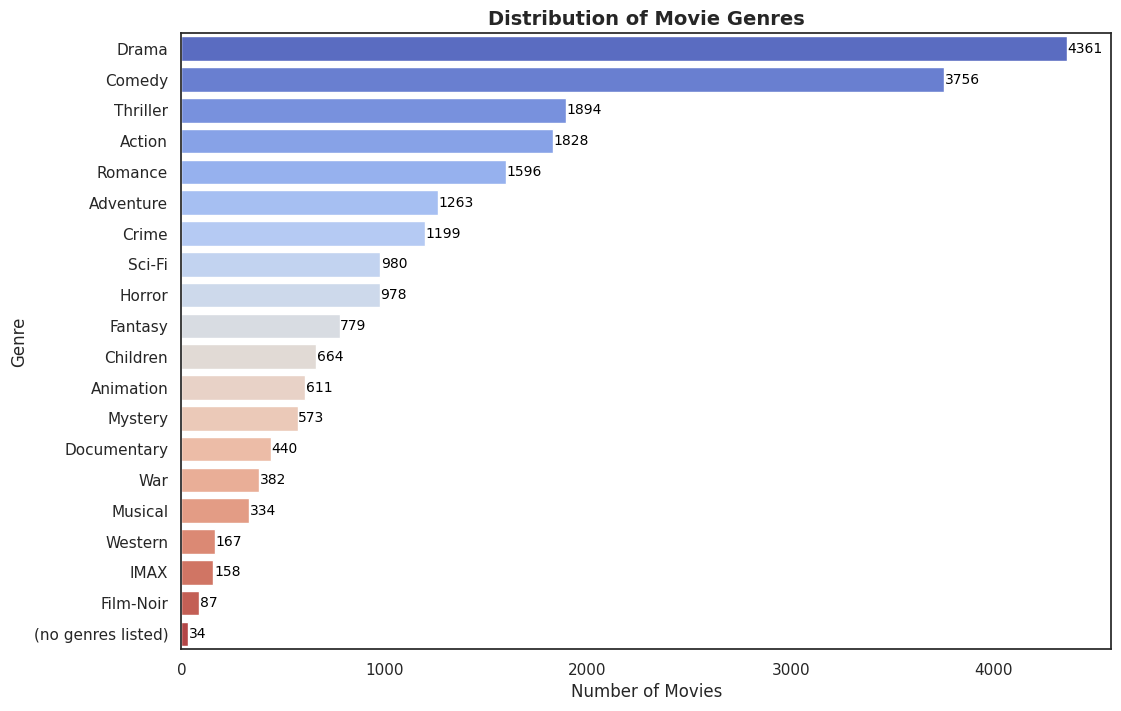

In [ ]:
# Movie Genre Distribution
genres_list = movies['genres'].str.split('|').explode()
genre_counts = genres_list.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

plt.figure(figsize=(12, 8))
ax3 = sns.barplot(data=genre_counts, x='Count', y='Genre', hue='Genre', palette='coolwarm', legend=False)

plt.title('Distribution of Movie Genres', fontsize=14, fontweight='bold')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

# Number on column
for i, v in enumerate(genre_counts['Count']):
    ax3.text(v + 3, i, str(v), color='black', va='center', fontsize=10)
plt.show()

**Chart 5: Movies Released per Year** (Số lượng phim phát hành mỗi năm)

**Thời gian**: Dữ liệu bao quát các phim được phát hành và đánh giá trong khoảng thời gian từ 1996 - 09/2018

**Cmt**:
*   Số lượng phim phát hành tăng trưởng mạnh từ sau năm 2000 => sự bùng nổ của ngành công nghiệp điện ảnh trong kỷ nguyên số
* Năm 2018: Dữ liệu chưa đầy đủ, cập nhật đến 26/09 => Số lượng phim có sự sụt giảm
*   Sparsity: 9,742 bộ phim nhưng chỉ có 610 người dùng, số lượng phim mới tăng nhanh hằng năm là lý do ma trận dữ liệu trở nên thưa thớt, độ loãng cao => Sử dụng thuật toán ALS để xử lý

Lưu ý: 13 phim không trích xuất đc năm phát hành đã loại bỏ khỏi biểu đồ để đảm bảo tính nhất quán tuyệt đối.





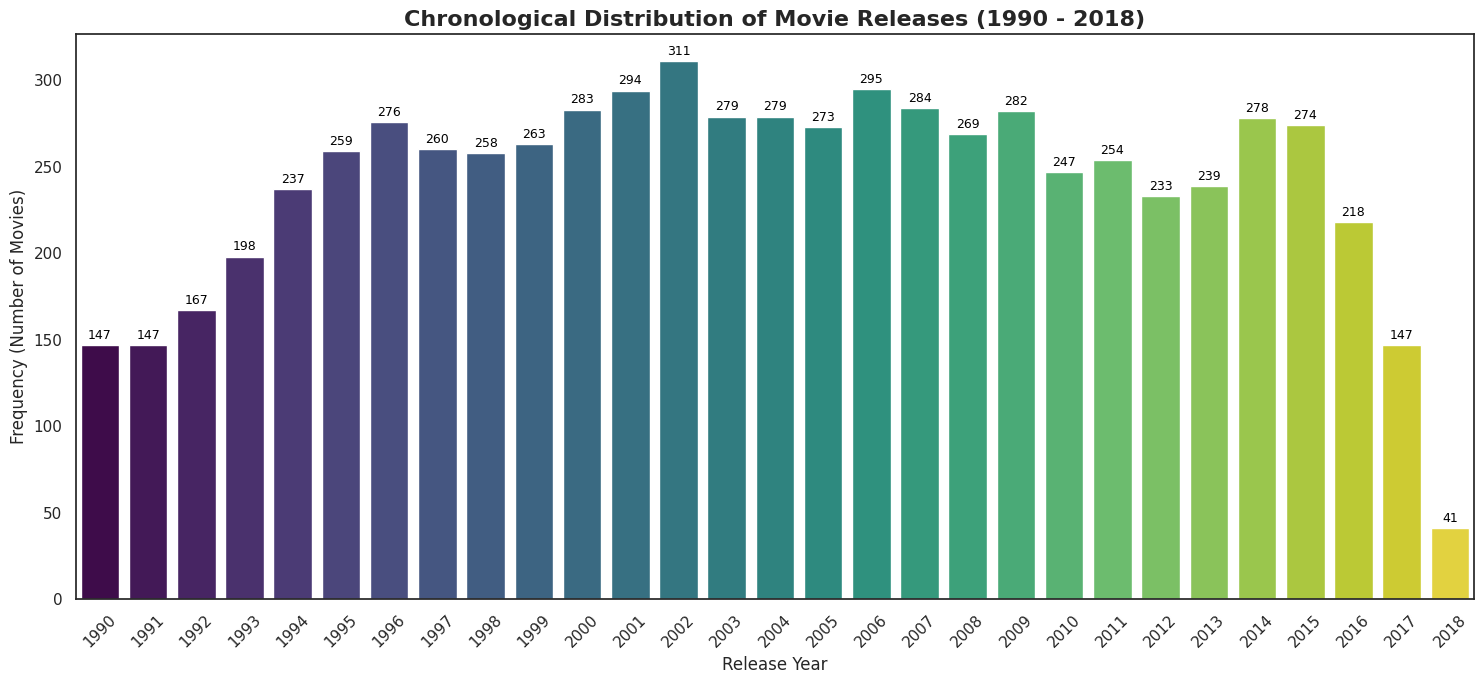

Total movies processed: 9742
Movies excluded due to format errors: 13
Validated records for this chart: 6992


In [ ]:
# Standard format expected: "Title (YYYY)"
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Remove 13 movies
movies_cleaned = movies.dropna(subset=['year']).copy()
movies_cleaned['year'] = movies_cleaned['year'].astype(int)

# Filtering: 1990 - 09/2018
recent_movies = movies_cleaned[(movies_cleaned['year'] >= 1990) & (movies_cleaned['year'] <= 2018)]

# 5. Aggregate data for plotting
year_counts = recent_movies['year'].value_counts().sort_index().reset_index()
year_counts.columns = ['Year', 'Movie_Count']

# 6. Visualization
plt.figure(figsize=(15, 7))
sns.set_theme(style="white")

# Fix: Assigning 'Year' to 'hue' to avoid future warnings
ax = sns.barplot(data=year_counts, x='Year', y='Movie_Count', hue='Year', palette='viridis', legend=False)

plt.title('Chronological Distribution of Movie Releases (1990 - 2018)', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Frequency (Number of Movies)', fontsize=12)
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    fontsize=9, color='black',
                    xytext=(0, 7),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

# Print confirmation for the report
print(f"Total movies processed: {len(movies)}")
print(f"Movies excluded due to format errors: {len(movies) - len(movies_cleaned)}")
print(f"Validated records for this chart: {len(recent_movies)}")

**Trích xuất 13 phim bị lỗi định dạng**

In [ ]:
movies['extracted_year'] = movies['title'].str.extract(r'\((\d{4})\)')

# 13 phim không đúng định dạng file movies.csv
error_movies = movies[movies['extracted_year'].isna()].copy()
error_movies['csv_line'] = error_movies.index + 2

header = f"{'CSV Line':<12} | {'movieId':<12} | {'Title (Left-aligned)':<50}"
print(header)
print("-" * 85)

for _, row in error_movies.iterrows():
    line = f"{str(row['csv_line']):<12} | {str(row['movieId']):<12} | {str(row['title']):<50}"
    print(line)

CSV Line     | movieId      | Title (Left-aligned)                              
-------------------------------------------------------------------------------------
6061         | 40697        | Babylon 5                                         
9033         | 140956       | Ready Player One                                  
9093         | 143410       | Hyena Road                                        
9140         | 147250       | The Adventures of Sherlock Holmes and Doctor Watson
9181         | 149334       | Nocturnal Animals                                 
9261         | 156605       | Paterson                                          
9369         | 162414       | Moonlight                                         
9450         | 167570       | The OA                                            
9516         | 171495       | Cosmos                                            
9517         | 171631       | Maria Bamford: Old Baby                           
9520         | 171749 

**Chart 6: User Rating Behavior Analysis** (Phân tích hành vi đánh giá của người dùng)

Trực quan hóa phân phối điểm đánh giá trung bình của 610 users => Hiểu được cách đánh giá của user

*   Histongram Bars: Thể hiện tần suất người dùng, biết đc số lượng người dùng có mức điểm trung bình nằm trong một khoảng nhất định.
*   KDE: Thể hiện xu hướng phân phối mật độ





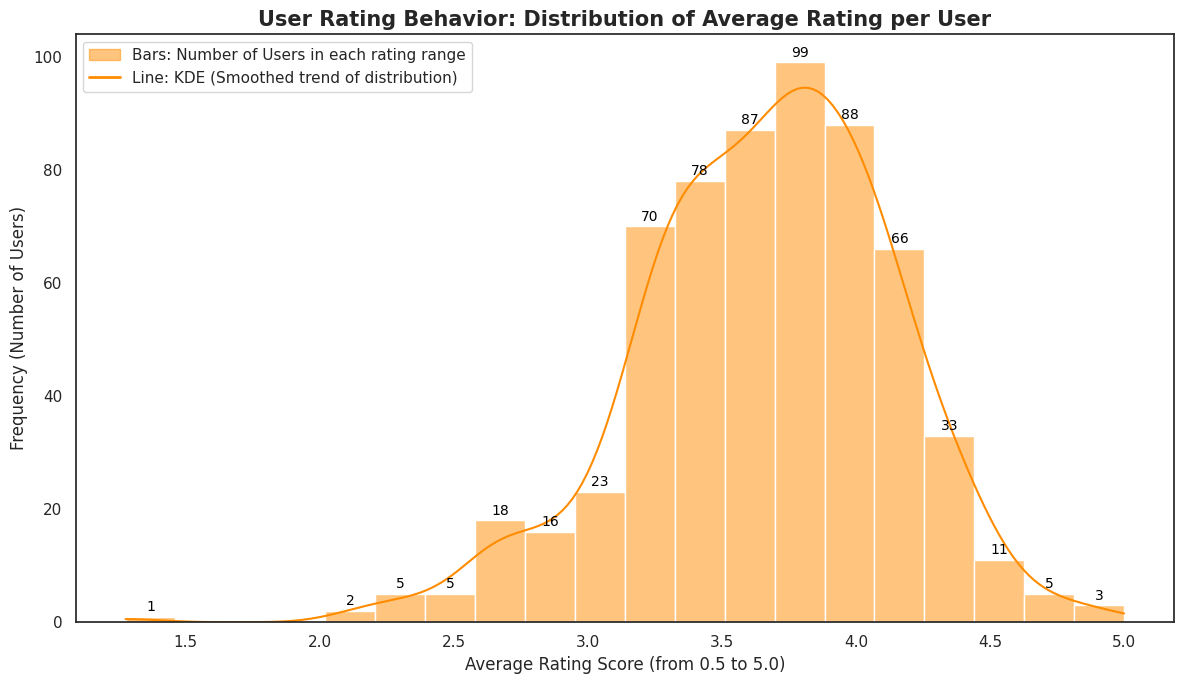

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tính toán điểm trung bình cho mỗi người dùng
user_means = ratings.groupby('userId')['rating'].mean().reset_index(name='avg_rating')

# 2. Thiết lập giao diện
plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

# 3. Vẽ biểu đồ Histogram kết hợp KDE
# Gán nhãn trực tiếp để hiển thị trong Legend
ax = sns.histplot(data=user_means, x='avg_rating', bins=20, color='darkorange', kde=True)

# 4. Tùy chỉnh Legend (Chú thích)
# Tạo các đối tượng giả để đưa vào Legend giải thích Cột và Line
from matplotlib.lines import Line2D
custom_lines = [plt.Rectangle((0,0),1,1, color='darkorange', alpha=0.5),
                Line2D([0], [0], color='darkorange', lw=2)]
plt.legend(custom_lines, ['Bars: Number of Users in each rating range',
                          'Line: KDE (Smoothed trend of distribution)'],
           loc='upper left', fontsize=11)

# 5. Thêm tiêu đề và nhãn trục
plt.title('User Rating Behavior: Distribution of Average Rating per User', fontsize=15, fontweight='bold')
plt.xlabel('Average Rating Score (from 0.5 to 5.0)', fontsize=12)
plt.ylabel('Frequency (Number of Users)', fontsize=12)

# 6. Hiển thị số lượng người dùng cụ thể trên mỗi cột
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 7),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

**Chart 7: Popularity Bias (Định kiến phổ biến)**


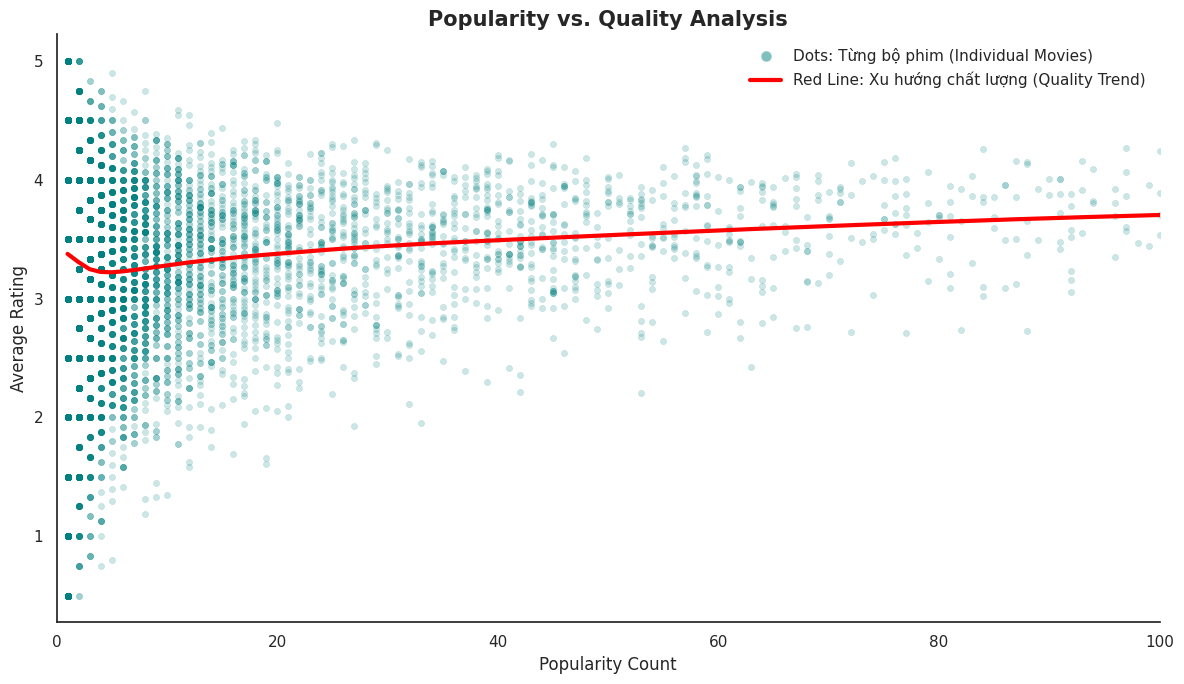

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1. Chuẩn bị dữ liệu
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']}).reset_index()
movie_stats.columns = ['movieId', 'mean_rating', 'rating_count']

plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

# 3. Vẽ biểu đồ Scatter Plot (Các điểm dữ liệu)
sns.scatterplot(data=movie_stats, x='rating_count', y='mean_rating',
                color='teal', s=20, alpha=0.2, edgecolor=None)

# 4. Vẽ đường xu hướng (Trend Line)
sns.regplot(data=movie_stats, x='rating_count', y='mean_rating',
            scatter=False, color='red', lowess=True,
            line_kws={'linewidth': 3})

# 5. FIX LỖI LEGEND: Tạo chú giải song ngữ thủ công
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='teal', markersize=8, alpha=0.5, label='Dots: Từng bộ phim (Individual Movies)'),
    Line2D([0], [0], color='red', lw=3, label='Red Line: Xu hướng chất lượng (Quality Trend)')
]
plt.legend(handles=custom_legend, loc='upper right', frameon=False, fontsize=11)

plt.xlim(0, 100)

plt.title('Popularity vs. Quality Analysis', fontsize=15, fontweight='bold')
plt.xlabel('Popularity Count', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

# 3. Recommendation Systems & Thuật toán ALS

**1. Recommendation Systems:**

Hệ khuyến nghị là một dạng của hệ thống lọc thông tin, dự đoán mức độ yêu thích của người dùng đối với một item mà user chưa từng tương tác => đồ án: dự đoán điểm số phim mà 610 users chưa xem để đưa ra gợi ý phù hợp.

Có 3 cách tiếp cận:

* Lọc dựa trên nội dung (CBF): Dựa trên đặc tính của sản phẩm. User xem nhiều action movies hệ thống sẽ gợi ý các phim tương tự cùng thể thoại.
* Lọc cộng tác (CF): Học từ hành vi tương đồng của người dùng. Nếu User A và User B có lịch sử đánh giá phim giống nhau, hệ thống sẽ lấy những phim User B thích để gợi ý cho User A or ngược lại.
*   Hybrid Recommender: Kết hợp cả CBF và CF

**=> Đề xuất áp dụng Hybrid Recommendation**

References: https://arxiv.org/pdf/2405.05562v2

Lý do:

* Giải quyết bài toán Sparisty (độ thưa dữ liệu là 98,3%): Sử dụng thuật toán ALS (Model-based CF) -> tìm ra các yếu tố ẩn => dự đoán rating cho các ô trống trong ma trận.
* Bài toán Cold Start(New movies_user): Khi phim chưa có rating, sử dụng CBF dựa trên đặc tính phim (movies.csv) và từ khóa (tags.csv) => gợi ý phim phù hợp.
* Hybrid: Kết hợp kết quả ALS với CBF để tăng độ tin cậy.

**Flow:**

* CF: Sử dụng ratings.csv -> Model ALS -> $Score_{ALS}$ (Dự đoán điểm số dựa trên hành vi cộng đồng)
* CBF:  Sử dụng movies.csv (Genres) và tags.csv -> $Score_{Content}$ (Tính toán độ tương đồng nội dung)
*   Hybird score => Top 10 movies recommendation:
$$Final\_Score = (\alpha \times Score_{ALS}) + (\beta \times Score_{Content})$$

![Workflow] (images/Workflow.png)

**2. Thuật toán ALS** Thuộc loại lọc cộng tác dựa trên mô hình (Model based)

**1. Cơ chế:** ALS là một kỹ thuật Matrix Factorization (Phân rã ma trận). Chia ma trận lớn (User-Item) thành 2 ma trận nhỏ hơn: Ma trận người dùng (U) và Ma trận đặc tính phim (I).

* **Phân rã ma trận**: Ma trận đánh giá gốc R (m người dùng x n phim <=> 610 x 9.742) $$R \approx U \times I^T$$
     Trong đó:

     $R$ (Rating Matrix): Ma trận chứa các điểm đánh giá thực tế từ ratings.csv

     $U$ (User Matrix): Ma trận người dùng kích thước $m \times k$. Mỗi dòng là một vector biểu diễn sở thích ẩn của một người dùng

     $I$ (Item Matrix): Ma trận mục tiêu (phim) kích thước $n \times k$. Mỗi dòng là một vector biểu diễn các đặc tính ẩn của một bộ phim.

     k (Rank): Số lượng các đặc trưng ẩn (Latent Factors)

* **Phương pháp tối ưu luân phiên**: ALS thực hiện cơ chế lặp luân phiên để tìm ra giá trị trong $U$ và $I$ sao cho sai số là nhỏ nhất

    - Cố định $I$: Giải bài toán tối ưu để tìm ma trận người dùng $U$.
    - Cố định $U$: Giải bài toán tối ưu để tìm ma trận mục tiêu $I$.
    - Quá trình này lặp lại cho đến khi đạt số vòng lặp tối đa (maxIter) hoặc sai số hội tụ.

**2. Công thức**

**1.   Scoring** (Dự đoán điểm số)

- Điểm số dự đoán $\hat{r}_{u,i}$ của người dùng $u$ cho bộ phim $i$ là tích vô hướng của vector người dùng $u$ (từ ma trận $U$) và vector phim $i$ (từ ma trận $I$):
$$Score_{ALS}(u, i) = \hat{r}_{u,i} = \vec{u}_u \cdot \vec{i}_i^T$$

**2.   Objective Function** (Hàm mục tiêu)

- Để mô hình không bị Overfitting vào 1.7% dữ liệu hiện có, công thức tối ưu hóa bao gồm thành phần điều chuẩn ($\lambda$):
$$\min_{U,I} \sum_{(u,i) \in R} (r_{u,i} - \vec{u}_u \vec{i}_i^T)^2 + \lambda (\|\vec{u}_u\|^2 + \|\vec{i}_i\|^2)$$

    Trong đó $r_{u,i}$ là điểm thật trong ma trận $R$, còn $\lambda$ là tham số regParam trong Spark
**3.   Hybrid Recommendation System** (Mô hình đề xuất lai): Kết hợp kết quả từ ALS (CF) và đặc tính nội dung từ Genres/Tags (CBF)

$$Final\_Score(u, i) = (\alpha \times Score_{ALS}) + (\beta \times Score_{Content})$$

Trong đó:

 - $Score_{ALS}$: Điểm dự đoán từ ma trận $U$ và $I$ (phản ánh hành vi cộng đồng)

 - $Score_{Content}$: Điểm tương đồng dựa trên Thể loại (Genres) và Tags từ file movies.csv và tags.csv.

 - $\alpha, \beta$: Các trọng số fine-tuning     

 **4. Đánh giá mô hình (Evaluation)**

  * Chỉ số: Sử dụng RMSE để đo lường độ lệch của $Score_{ALS}$.

  
  * Phương pháp: Chia dữ liệu theo thời gian dựa trên cột *timestamp*. Tỉ lệ 7-3 or 8-2, tương ứng với data cũ để train, data mới (2018) để test















